
##### <ins>Installing required packages (if missing)</ins>

In [83]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost

##### <ins>Import required libs</ins>

In [84]:
import pandas as pd
import matplotlib.pyplot

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##### <ins>Taking a look at the DFs head:</ins>

In [85]:
gyro = pd.read_csv('../datasets/gyro_mobile.csv')
print(gyro.head())

       accX      accY      accZ     gyroX     gyroY     gyroZ timestamp  \
0 -0.496517  3.785628  8.954828 -0.142849 -0.126159 -0.022539   34:22.9   
1 -0.462388  3.869603  9.281898  0.084349  0.096695  0.092130   34:23.0   
2 -0.296084  3.820505  8.930728  0.061763  0.051543  0.071287   34:23.1   
3 -0.469723  3.890110  8.744067  0.007641  0.028679  0.109433   34:23.2   
4 -0.472418  4.109105  8.941207 -0.123640  0.099057  0.051943   34:23.3   

   Activity  
0         1  
1         1  
2         1  
3         1  
4         1  


In [86]:
gyroCols = gyro.columns.to_list()
for col in gyroCols:
    print(f"Column: {col} \n{gyro[col].describe()} \nData Type: {gyro[col].dtype}\n")

Column: accX 
count    31991.000000
mean         0.023825
std          0.741396
min         -3.673361
25%         -0.472193
50%         -0.024998
75%          0.477208
max          4.678671
Name: accX, dtype: float64 
Data Type: float64

Column: accY 
count    31991.000000
mean         2.153858
std          1.085466
min         -4.386029
25%          1.413062
50%          2.119143
75%          2.928435
max          6.377039
Name: accY, dtype: float64 
Data Type: float64

Column: accZ 
count    31991.000000
mean         9.537909
std          2.056358
min          4.296066
25%          7.794217
50%          9.406739
75%         11.158845
max         17.591568
Name: accZ, dtype: float64 
Data Type: float64

Column: gyroX 
count    31991.000000
mean        -0.004493
std          0.307643
min         -1.470421
25%         -0.149783
50%          0.022301
75%          0.177978
max          1.332722
Name: gyroX, dtype: float64 
Data Type: float64

Column: gyroY 
count    31991.000000
mean     

Insights:
- 31991 data points
- Every feature is continuous
- Activity is either 1 or 0 (binary classification)
- Dataset contains a timestamp that might be dropped

##### <ins>Dropping timestamp and splitting data into training and testing</ins>

In [87]:
gyro = gyro.drop(columns='timestamp')

xtrain, xtest, ytrain, ytest = train_test_split(
    gyro.iloc[:,:6],
    gyro.iloc[:,6:],
    test_size=0.2,
    random_state=0
)

##### <ins>Training and Evaluating</ins><br>
Um eine gute Anzahl an Estimators zu bestimmen, wird zuerst ein Modell mithilfe von Early Stopping, sowie einer großen Menge an Estimatoren trainiert. Hiermit wird die beste Anzahl an Iterationen ermittelt und mit dieser Anzahl ein weiteres Modell trainiert.

In [ ]:
preModel = XGBClassifier(           # "Spendermodell"
    objective='binary:logistic',
    n_estimators=10000,             # "Große Anzahl an Schaetzern, die nicht erreicht werden soll"
    early_stopping_rounds=20,      # Anzahl an Runden, bei denen sich das Modell nicht verbessern muss, bis abgebrochen wird
    max_depth=2,
    learning_rate=0.1
)

evaldata=[(xtrain,ytrain),(xtest,ytest)]          # Datensatz zur Evaluierung

preModel.fit(xtrain, ytrain, eval_set=evaldata, verbose=False)

bIter = preModel.best_iteration     # Beste Anzahl an Estimatoren
print(f'Best Iteration: {bIter}')

model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=bIter,
    max_depth=2,
    learning_rate=0.1
)

model.fit(xtrain, ytrain, eval_set=evaldata, verbose=False)

yhat = model.predict(xtest)
print(accuracy_score(ytest, yhat))

Best Iteration: 355
0.9837474605407095


##### <ins>Performance Metrics and Evaluation</ins>

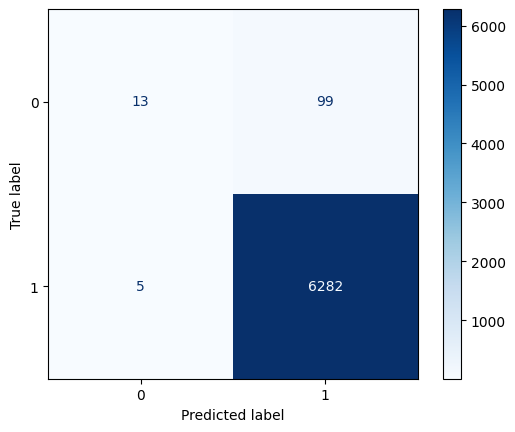

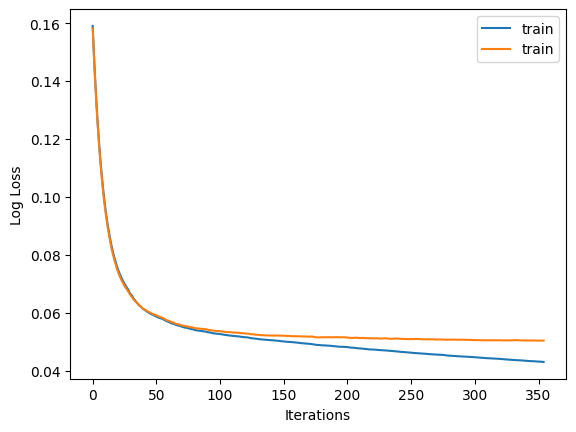

              precision    recall  f1-score   support

           0      0.722     0.116     0.200       112
           1      0.984     0.999     0.992      6287

    accuracy                          0.984      6399
   macro avg      0.853     0.558     0.596      6399
weighted avg      0.980     0.984     0.978      6399

# Trees: 	355
Test Accuracy: 	0.9837474605407095
[[1.11699104e-04 9.99888301e-01]
 [4.81605530e-05 9.99951839e-01]
 [5.56047559e-02 9.44395244e-01]
 ...
 [1.29938126e-05 9.99987006e-01]
 [2.04014778e-03 9.97959852e-01]
 [1.90794468e-04 9.99809206e-01]]


In [89]:
from sklearn import metrics
import matplotlib.pyplot as pyplot

# Confusion Matrix
metrics.ConfusionMatrixDisplay.from_estimator(model, xtest, ytest, cmap='Blues')
pyplot.show()

# Loss Curves
# save evaluation results
results = model.evals_result()
# plot curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='train')
# show the legend
pyplot.xlabel('Iterations')
pyplot.ylabel('Log Loss')
pyplot.legend()
# show the plot
pyplot.show()

# Report
print(metrics.classification_report(ytest, yhat, digits = 3))

# Misc
print(f'# Trees: \t{bIter}')
print(f'Test Accuracy: \t{metrics.accuracy_score(ytest, yhat)}')

print(model.predict_proba(xtest))

##### <ins>Porting this Bitch</ins>

In [90]:
def portToC(model):
    import m2cgen as m2c

    model.base_score = 0 #workaround

    with open('../exported_models/gyro.c','w') as f:
        code = m2c.export_to_c(model)
        f.write(code)
        

##### <ins>Generating Code for Lazy People</ins>

In [91]:
def printFloat(start=0, size=500, time=100):
    start = start
    size = size
    time = time
    length = 2
    

    print(f'void infer() {{')
    print(f'\t// Printing Range:')
    print(f'\tSerial.println(\"Start: {start} | End: {start+size}\");\n')
    print(f'Serial.println("aScore0,aScore1");')

    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    print(f'\tfloat result[length];')
    print(f'\tint time = {time};\n')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):  
        print(f'\tfloat x_{x}[] = {{' , end="")    
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        # print(f'\tprintScoreCompare(result, length, y_{x});')
        print(f'\tprintScoreCompareCSV(result, length, y_{x});')
        print(f'\tdelay(time);\n')
    print(f'}}')

def printDouble(start=0, size=500, time=100):
    start = start
    size = size
    time = time
    length = 2

    print(f'void infer() {{')
    print(f'\t// Printing Range:')
    print(f'\tSerial.println(\"Start: {start} | End: {start+size}\");\n')
    print(f'Serial.println("aScore0,aScore1");')
    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    print(f'\tdouble result[length];')
    print(f'\tint time = {time};\n')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):
        print(f'\tdouble x_{x}[] = {{' , end="")        
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        # print(f'\tprintScoreCompare(result, length, y_{x});')
        print(f'\tprintScoreCompareCSV(result, length, y_{x});')
        print(f'\tdelay(time);\n')
    print(f'}}')

printFloat()
# printDouble()

void infer() {
	// Printing Range:
	Serial.println("Start: 0 | End: 500");

Serial.println("aScore0,aScore1");
	// Declarations:
	int length = 2;
	float result[length];
	int time = 100;

	// Model Inference
	float x_0[] = {-0.623154, 3.131787, 11.257041, -0.736, -0.059642, 0.56997};
	int y_0 = 1;
	score(x_0, result);
	printScoreCompareCSV(result, length, y_0);
	delay(time);

	float x_1[] = {1.366808, 2.376458, 11.491304, -0.219388, 0.297717, -0.341959};
	int y_1 = 1;
	score(x_1, result);
	printScoreCompareCSV(result, length, y_1);
	delay(time);

	float x_2[] = {-0.931214, 1.462459, 9.501641, 0.435188, 0.209586, 0.465394};
	int y_2 = 1;
	score(x_2, result);
	printScoreCompareCSV(result, length, y_2);
	delay(time);

	float x_3[] = {0.209265, 2.590363, 12.200529, 0.147434, -0.108728, -0.057775};
	int y_3 = 1;
	score(x_3, result);
	printScoreCompareCSV(result, length, y_3);
	delay(time);

	float x_4[] = {-0.111518, 1.748065, 8.976833, 0.754365, 0.03308, -0.407495};
	int y_4 = 1;
	score(x_4

In [92]:
# print(model.predict(xtest))
# print(model.predict_proba(xtest)[0][0].item())
# print(type(model.predict_proba(xtest)[0].tolist()))

print(len(model.predict(xtest)))

xtestlist = model.predict_proba(xtest).tolist()
list1 = []
list2 = []

for x in xtestlist:
    list1.append(round(x[0],4))
    list2.append(round(x[1],4))

probs = pd.DataFrame({
    'Label': model.predict(xtest),
    'Prob0': list1,
    'Prob1': list2
})

# print(probs)

probs = probs.truncate(after=499)
serial = pd.read_csv('../datasets/gyro-float-csv.csv')
probs = probs.join(serial)

probs.to_csv('../datasets/compared-gyro-float.csv')

6399
